# Поиск изображений по запросу

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

**Описание данных**

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Загрузим необходимые библиотеки и инструменты.

In [1]:
%%capture

import numpy as np
import pandas as pd
import os
from os.path import join

import random as rd

import spacy
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from math import ceil
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

Создадим константу, в которой пропишем путь к директории с данными.

In [2]:
dataset_path = '/project-4/to_upload'

Импортируем данные

In [3]:
train_dataset = pd.read_csv(os.path.join(dataset_path, 'train_dataset.csv'))
crowd_annotations = pd.read_csv(os.path.join(dataset_path, 'CrowdAnnotations.tsv'), sep='\t', header=None)
expert_annotations = pd.read_csv(os.path.join(dataset_path, 'ExpertAnnotations.tsv'), sep='\t', header=None)
test_queries = pd.read_csv(os.path.join(dataset_path, 'test_queries.csv'), sep='|', index_col=0)
test_images = pd.read_csv(os.path.join(dataset_path, 'test_images.csv'), sep='|')

Изучим набор данных, для упрощения этого создадим функцию

In [4]:
def info_data(name, data):
    print('*' * len(name))
    print(name)
    print('*' * len(name))
    display(data.head())
    data.info()
    display(data.describe())
    print('_' * 75)

Изучим таблицу `train_dataset`

In [5]:
info_data('train_dataset', train_dataset)

*************
train_dataset
*************


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


___________________________________________________________________________


Таблица содержит три столбца - имя файла изображения, идентификатор описания и текст описания. Всего в таблице 5822 записи, 1000 уникальных изображений, 977 уникальных описаний и их идентификаторов. Изображение встречается максимум в 10 записях, а одно описание встречается максимум 34 раза.

Изучим таблицу `crowd_annotations`

In [6]:
info_data('CrowdAnnotations', crowd_annotations)

****************
CrowdAnnotations
****************


,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,2,3,4
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


___________________________________________________________________________


Таблица содержит 5 столбцов - имя файла изображения; идентификатор описания; доля людей, подтвердивших, что описание соответствует изображению; количество человек, подтвердивших, что описание соответствует изображению; количество человек, подтвердивших, что описание не соответствует изображению. В таблице 47830 записей, всего около 7% описаний по мнению людей подходит изображению, при этом максимальное количество людей согласных, что описание подходит изображению - 5, а максимальное количество несогласных с этим - 6.

Изучим таблицу `expert_annotations`

In [7]:
info_data('ExpertAnnotations', expert_annotations)

*****************
ExpertAnnotations
*****************


,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,2,3,4
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


___________________________________________________________________________


Таблица содержит 5 столбцов - имя файла изображения; идентификатор описания; оценки трёх экспертов. В таблице 5822 записи. Минимальная оценка у каждого эксперта - 1, максимальная - 4, средняя оценка у каждого эксперта - 1,43 - 1,88.

Изучим таблицу `test_queries`

In [8]:
info_data('test_queries', test_queries)

************
test_queries
************


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


___________________________________________________________________________


Таблица содержит три столбца - идентификатор запроса, текст запроса и релевантное изображение. В таблице 500 уникальных записей, включающих 500 уникальных описаний и их идентификаторов, 100 уникальных имен изображений, которые повторяются максимум 5 раз.

Изучим таблицу `test_images`

In [9]:
info_data('test_images', test_images)

***********
test_images
***********


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


___________________________________________________________________________


Таблица содержит 1 столбец, в котором 100 записей, включающих 100 уникальных имён изображений.

**Вывод**

Изучив предоставленные данные, можно сказать следующее:
 - тренировочный датасет содержит 5822 записи, на 1000 уникальныз изображений- 977 уникальных записей, на одно изображение может приходиться 10 описаний, а сами описания могут встречаться 34 раза. Также видно, что идентификатор описания часто не соответствует изображению;
 - таблица с краудсорс-оценками имеет 47830 записей, в большинстве случаев идентификатор описания не соответствует изображению, поэтому оценка в большинстве случаев в столбце, в котором пользователи несогласны с описанием;
 - таблица с оценками экспертов содержит 5822 записи, столько же сколько в тренировочном датасете, однако и здесь зачастую индентификатор описания не соответствует изображению, поэтому в большинстве случаев эксперты ставят заниженную оценку;
 - в тестовом датасете иеется 500 записей, 100 уникальных изображений, на которые приходится по пять записей. Все записи уникальны.

## Предобработка

Для получения большего объёма данных для обучения модели объединим таблицы `expert_annotations` и `crowd_annotations`, предварительно подсчитав среднюю оценку экспертов. Переименовав столбцы в обоих таблицах, для наилучшего понимания их содержания. Объединение произведем следующим образом - применим фунцию merge() по столбцам 'image' и 'annotation_id' с параметром how='outer'. Получим новую таблицу `train_data` с тремя столбцами - имя изображения, идентификатор описания изображения и результирующая оценка `res`. В тех строках, в которых имеется только краудсорс-оценка, в столбец `res` попадет только она целиком (либо 0 либо 1). В тех строках, в которых имеется только усредненая оценка экспертов, в столбец `res` попадет только она целиком (число типа float от 0 до 1). В тех строках, где имеются обе оценки - в столбец `res` попадет сумма чисел - оцеки экспертов с коэффициентом 0,6 и краудсорс-оценки с коэффициентом 0,4.

In [10]:
expert_annotations.columns = ['image', 'annotation_id', 'score_1', 'score_2', 'score_3']

In [11]:
expert_annotations['expert'] = expert_annotations['score_1'] + expert_annotations['score_2'] + expert_annotations['score_3']

mms = MinMaxScaler()
expert_annotations['expert'] = mms.fit_transform(expert_annotations[['expert']])

In [12]:
expert_annotations.head()

,image,annotation_id,score_1,score_2,score_3,expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.111111


In [13]:
crowd_annotations.columns = ['image', 'annotation_id', 'score', 'positive', 'negative']

In [14]:
crowd_annotations.head()

,image,annotation_id,score,positive,negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [15]:
train_data = expert_annotations.merge(crowd_annotations, left_on=['image', 'annotation_id'], right_on=['image', 'annotation_id'], how='outer')[['image', 'annotation_id', 'expert', 'score']]
def calc_res(row):
    if pd.isna(row['expert']) and pd.isna(row['score']):
        return np.nan
    elif pd.isna(row['expert']):
        return row['score']
    elif pd.isna(row['score']):
        return row['expert']
    else:
        return row['expert']*0.6 + row['score']*0.4

train_data['res'] = train_data.apply(calc_res, axis=1)
train_data.head()

,image,annotation_id,expert,score,res
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111,0.0,0.066667
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,NaN,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,NaN,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,NaN,0.111111


In [16]:
train_data = train_data[['image', 'annotation_id', 'res']]
train_data.head()

,image,annotation_id,res
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.066667
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111


In [17]:
train_data.shape

(51323, 3)

Получили таблицу `train_data` с 51323 строками, в которой три столбца 'image' - имя изображения, 'annotation_id' - идентификатор описания и 'res' - наша целевая переменная оценка соответствия описания изображению, float-число от 0 до 1.

Сосдадим новый датафрейм, в который войдут уникальные пары "id-описания/описание".

In [18]:
train_df = train_dataset.drop_duplicates(subset=['query_id', 'query_text']).reset_index(drop=True)
train_df

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .
...,...,...,...
972,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
973,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
974,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
975,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       977 non-null    object
 1   query_id    977 non-null    object
 2   query_text  977 non-null    object
dtypes: object(3)
memory usage: 23.0+ KB


Объединим таблицы `train_df` и `train_data`, получим уникальные значения изображение/идентификатор/описание/оценка.

In [20]:
train_df = train_df.merge(train_data, left_on=['query_id'], right_on=['annotation_id'], how='inner')

In [21]:
train_df = train_df.drop(['image_x', 'annotation_id'], axis=1)
train_df.rename(columns = {'image_y':'image'}, inplace = True)

In [22]:
train_df.head()

,query_id,query_text,image,res
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1056338697_4f7d7ce270.jpg,0.000000
1,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1262583859_653f1469a9.jpg,0.000000
2,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2447284966_d6bbdb4b6e.jpg,0.133333
3,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2549968784_39bfbe44f9.jpg,1.000000
4,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2621415349_ef1a7e73be.jpg,0.000000


In [23]:
train_df.shape

(50214, 4)

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50214 entries, 0 to 50213
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   query_id    50214 non-null  object 
 1   query_text  50214 non-null  object 
 2   image       50214 non-null  object 
 3   res         50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


Проверим датафрейм на дубликаты.

In [25]:
train_df.duplicated().sum()

0

**Вывод**

При подготовке данных сделали следующее:
- вычислили среднюю оценку экспертов;
- объединили таблицы с экспертными и краудсорос-оценками, получили столбец с общей оценкой;
- сделали датафрейм с уникальными парами "id-описания/описание";
- объединили таблицы с описаниями и оценками в один датафрейм.

В результате мы получили датафрейм с 50214 строками, готовый к работе по нашим задачам.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для того чтобы удалить изображения, на котрых изображены дети, создадим список слов 'child_dict', которые соответствуют описанию детей и чаще всего встречаются в описании изображений с детьми. Дальше лемматизируем текст описания, чтобы все слова были в нормальной словарной форме. Добавим в `train_df` столбец с лемматизированным описанием. Добавим туда столбец 'without_child' с идентификатором наличия в описании слова из списка 'child_dict', где True - это отсутствие слова, а False - наличие слова из списка. Таким образом найдём все изображения, где встречаются дети.

In [26]:
child_dict = ['child', 
              'baby', 
              'boy', 
              'girl', 
              'teenager', 
              'schoolboy', 
              'youth', 
              'newborn', 
              'kid', 
              'babe', 
              'infant', 
              'juvenile', 
              'teener', 
              'stripling']

In [27]:
nlp = spacy.load("en_core_web_sm")

def lemma_clear(text):
    lemm = nlp(text)
    lemm = " ".join([token.lemma_ for token in lemm])


    return " ".join(lemm.split())

In [28]:
lemm_train = train_df['query_text'].apply(lemma_clear)
lemm_train.head()

0    a young child be wear blue goggle and sit in a...
1    a young child be wear blue goggle and sit in a...
2    a young child be wear blue goggle and sit in a...
3    a young child be wear blue goggle and sit in a...
4    a young child be wear blue goggle and sit in a...
Name: query_text, dtype: object

In [29]:
lemm_test = test_queries['query_text'].apply(lemma_clear)
lemm_test.head()

0    two blonde boy , one in a camouflage shirt and...
1          two boy be squirt water gun at each other .
2                  two boy spray each other with water
3     two child wear jean squirt water at each other .
4        two young boy be squirt water at each other .
Name: query_text, dtype: object

In [30]:
train_df['lem_text'] = lemm_train

In [31]:
def child_text(text):
    for s in child_dict: 
        if text.find(s) > -1:
            return False
    return True

In [32]:
train_df['without_child'] = lemm_train.apply(child_text)
train_df.head()

,query_id,query_text,image,res,lem_text,without_child
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1056338697_4f7d7ce270.jpg,0.000000,a young child be wear blue goggle and sit in a...,False
1,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1262583859_653f1469a9.jpg,0.000000,a young child be wear blue goggle and sit in a...,False
2,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2447284966_d6bbdb4b6e.jpg,0.133333,a young child be wear blue goggle and sit in a...,False
3,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2549968784_39bfbe44f9.jpg,1.000000,a young child be wear blue goggle and sit in a...,False
4,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2621415349_ef1a7e73be.jpg,0.000000,a young child be wear blue goggle and sit in a...,False


In [33]:
def spl(text):
    return text[:text.find('#')]

In [34]:
num_forb_images = len(train_df[train_df['without_child']==False]['query_id'].apply(spl).unique())

In [35]:
num_forb_images

291

В трентровочных данных мы нашли 291 изображение с детьми. Создадим новую таблицу, в которую войдут только те строки, которые не содержат детские изображения.

In [36]:
train_df = train_df[train_df['without_child'] != False].reset_index(drop=True)

In [37]:
train_df.head()

,query_id,query_text,image,res,lem_text,without_child
0,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1056338697_4f7d7ce270.jpg,0.111111,a man sleep under a blanket on a city street .,True
1,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,3187395715_f2940c2b72.jpg,0.222222,a man sleep under a blanket on a city street .,True
2,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,463978865_c87c6ca84c.jpg,0.200000,a man sleep under a blanket on a city street .,True
3,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,488590040_35a3e96c89.jpg,0.222222,a man sleep under a blanket on a city street .,True
4,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,534875358_6ea30d3091.jpg,0.111111,a man sleep under a blanket on a city street .,True


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35968 entries, 0 to 35967
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   query_id       35968 non-null  object 
 1   query_text     35968 non-null  object 
 2   image          35968 non-null  object 
 3   res            35968 non-null  float64
 4   lem_text       35968 non-null  object 
 5   without_child  35968 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 1.4+ MB


После удаления из датасета строк с изображениями детей и соответствующим описанием получили таблицу в которой 35968 строк.

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для векторизации изображений применим преnренерованную модель Resnet18, веса заморозим. Уберём последние два слоя, чтобы получить вектор. На примере одного изображения посмотрим какой получился вектор.

In [39]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)
    
print(list(resnet.children())) 

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules) 

resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [40]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [41]:
img = Image.open(os.path.join(dataset_path, 'train_images/1056338697_4f7d7ce270.jpg')).convert('RGB')

In [42]:
image_tensor = preprocess(img)
output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
output_tensor.size()

torch.Size([512])

Получили вектор с размерностью 512.

На основе этой модели преобразуем все изображения в тренировочном датасете в векторы.

In [43]:
def vect_gen(string):
    img = Image.open(path+string['image']).convert('RGB')
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    output_tensor.size()
    return output_tensor.numpy()

In [44]:
path=os.path.join(dataset_path, 'train_images/')
train_img_vec_arr = np.array(train_df.apply(vect_gen, axis=1))

Вектора изображений получены.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для векторизации текстов применим tf-idf, попутно удалим стоп-слова. 

In [45]:
corpus = train_df['lem_text']

count_tf_idf = TfidfVectorizer(stop_words='english') 

tf_idf_train = count_tf_idf.fit_transform(corpus) 

print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (35968, 910)


Преобразовали тренировочный датасет. Получили матрицу размером 35968 х 910.

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

Объединим вектора текстов и изображений по горизонтали с помощью функции np.hstack()

In [46]:
train_mass = np.hstack([np.vstack(train_img_vec_arr), tf_idf_train.toarray()])
train_mass

array([[0.69394064, 3.03183556, 2.9169333 , ..., 0.        , 0.        ,
        0.        ],
       [0.27191308, 2.48227429, 1.61997378, ..., 0.        , 0.        ,
        0.        ],
       [0.98070043, 3.8292675 , 1.29665279, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.12389877, 2.38879728, 3.07900405, ..., 0.        , 0.        ,
        0.        ],
       [1.2478894 , 0.92793214, 1.17643476, ..., 0.        , 0.        ,
        0.        ],
       [0.14679863, 3.52485752, 1.2126931 , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
train_mass.shape

(35968, 1422)

После объединения векторов изображений и текстов получили матрицу размером 35968 х 1422.

Объединим полученные вектора с таблицей `train_dataset_clear` и получим новую таблицу `new_train_data`

In [48]:
for i in range(train_mass.shape[1]):
    train_df[f'new_col_{i}'] = train_mass[:, i]

In [49]:
train_df.head()

,query_id,query_text,image,res,lem_text,without_child,new_col_0,new_col_1,new_col_2,new_col_3,...,new_col_1412,new_col_1413,new_col_1414,new_col_1415,new_col_1416,new_col_1417,new_col_1418,new_col_1419,new_col_1420,new_col_1421
0,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1056338697_4f7d7ce270.jpg,0.111111,a man sleep under a blanket on a city street .,True,0.693941,3.031836,2.916933,0.951898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,3187395715_f2940c2b72.jpg,0.222222,a man sleep under a blanket on a city street .,True,0.271913,2.482274,1.619974,1.238906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,463978865_c87c6ca84c.jpg,0.200000,a man sleep under a blanket on a city street .,True,0.980700,3.829268,1.296653,0.803810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,488590040_35a3e96c89.jpg,0.222222,a man sleep under a blanket on a city street .,True,1.519510,1.070954,0.178771,0.297532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,534875358_6ea30d3091.jpg,0.111111,a man sleep under a blanket on a city street .,True,0.341053,3.860156,1.173058,0.526688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
train_df.sample()

,query_id,query_text,image,res,lem_text,without_child,new_col_0,new_col_1,new_col_2,new_col_3,...,new_col_1412,new_col_1413,new_col_1414,new_col_1415,new_col_1416,new_col_1417,new_col_1418,new_col_1419,new_col_1420,new_col_1421
29100,3578914491_36019ba703.jpg#2,Two dogs fight over a stick on a grassy field ...,2999730677_0cfa1c146e.jpg,0.0,"two dog fight over a stick on a grassy field ,...",True,0.169635,0.599869,0.780767,0.370752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В результате векторизации тектов и изображений и объединения этих веторов мы получили таблицу, в которой добававились 1422 новых признака.

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Для обучения попробуем две модели - линейную модель Lasso Regression и полносвязную нейронную сеть, но сначала построим константную модель Dummy Regressor, чтоб затем проверить результат работы наших моделей.

Метрикой выберем RMSE, так как она симметрична относительно знака ошибки и чувствительна к большим отклонениям.

С помощью GroupShuffleSplit разделим данные на тренировочную и тестовую выборки. Оставим только числовые признаки, целевой признак находится в колонке 'res'

In [51]:
gss = GroupShuffleSplit(n_splits=1, train_size=.6, random_state=42)
train_indexes, valid_indexes = next(gss.split(X=train_df.iloc[:, 6:], y=train_df['res'], groups=train_df['image']))

X_train = train_df.iloc[:, 6:].loc[train_indexes]
X_valid = train_df.iloc[:, 6:].loc[valid_indexes]
y_train = train_df['res'].loc[train_indexes]
y_valid = train_df['res'].loc[valid_indexes]

In [52]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

**Dummy Regressor**

In [53]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [54]:
print("RMSE Dummy Regressor:", mean_squared_error(y_valid, dummy_model.predict(X_valid), squared=False))

RMSE Dummy Regressor: 0.22975236306800592


Константная модель показала RMSE 0.23

**Lasso Regression**

In [55]:
model_lr = linear_model.Lasso(alpha=0.1)
model_lr.fit(X_train, y_train)

Lasso(alpha=0.1)

In [56]:
print("RMSE Lasso Regression:", mean_squared_error(y_valid, model_lr.predict(X_valid), squared=False))

RMSE Lasso Regression: 0.21427457004733444


Модель Lasso Regression показала метрику RMSE 0.214

**Построим полносвязную нейронную сеть**

In [57]:
X_train = torch.FloatTensor(np.array(X_train))
X_valid = torch.FloatTensor(np.array(X_valid))
y_train = torch.FloatTensor(np.array(y_train))
y_valid = torch.FloatTensor(np.array(y_valid))

In [58]:
X_train.shape

torch.Size([21458, 1422])

In [59]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
                 n_hidden_neurons_4, n_hidden_neurons_5, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
            self.act3 = nn.ReLU()
            self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
            self.act4 = nn.ReLU()
            self.fc5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
            self.act5 = nn.ReLU()
            self.fc6 = nn.Linear(n_hidden_neurons_5, n_out_neurons)
            self.act6 = nn.Sigmoid()
            
            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc6.weight, mode='fan_in', nonlinearity='sigmoid')
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)
        
        return x

Для улучшения работы нейросети используем оптимизатор SGD из библиотеки Keras.

In [60]:
n_in_neurons = 1422
n_hidden_neurons_1 = 512
n_hidden_neurons_2 = 256
n_hidden_neurons_3 = 128
n_hidden_neurons_4 = 64
n_hidden_neurons_5 = 32
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
          n_hidden_neurons_4, n_hidden_neurons_5, n_out_neurons)

optimizer2 = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.8)

optimizers = [optimizer2]

loss = nn.MSELoss()

In [61]:
num_epochs = 1000
batch_size = 150
num_batches = ceil(len(X_train)/batch_size)

best_rmse = float('inf')  # Инициализация лучшей RMSE

for optimizer in optimizers:
    optimizer_rmse = []
    print(f'Оптимизатор {optimizer}:')
    for epoch in range(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train))  
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
            batch_indexes = order[start_index : start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(X_batch.float()).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        # Проверка RMSE на валидационном наборе
        with torch.no_grad():
            net.eval()
            valid_preds = net.forward(X_valid).flatten()
            rmse = round(float(torch.sqrt(loss(valid_preds, y_valid))), 3)

            # Если текущая модель лучше предыдущей лучшей модели, сохраняем ее
            if rmse < best_rmse:
                best_rmse = rmse
                torch.save(net.state_dict(), 'best_model.pth')

            # Выводим результаты на каждой десятой итерации или на последней итерации
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f'RMSE на {epoch} итерации =', rmse)
                optimizer_rmse.append(rmse)

    print()
    print(f'Лучшая RMSE = {min(optimizer_rmse)} обнаружена на {optimizer_rmse.index(min(optimizer_rmse))} эпохе')
    print(f'Средняя RMSE = {round(np.mean(optimizer_rmse), 3)}')
    print('_' * 75, '\n')

Оптимизатор SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0.8
    nesterov: False
    weight_decay: 0
):
RMSE на 0 итерации = 0.341
RMSE на 10 итерации = 0.223
RMSE на 20 итерации = 0.218
RMSE на 30 итерации = 0.217
RMSE на 40 итерации = 0.216
RMSE на 50 итерации = 0.216
RMSE на 60 итерации = 0.216
RMSE на 70 итерации = 0.216
RMSE на 80 итерации = 0.216
RMSE на 90 итерации = 0.216
RMSE на 100 итерации = 0.215
RMSE на 110 итерации = 0.215
RMSE на 120 итерации = 0.215
RMSE на 130 итерации = 0.215
RMSE на 140 итерации = 0.215
RMSE на 150 итерации = 0.215
RMSE на 160 итерации = 0.215
RMSE на 170 итерации = 0.215
RMSE на 180 итерации = 0.215
RMSE на 190 итерации = 0.215
RMSE на 200 итерации = 0.215
RMSE на 210 итерации = 0.215
RMSE на 220 итерации = 0.214
RMSE на 230 итерации = 0.214
RMSE на 240 итерации = 0.214
RMSE на 250 итерации = 0.214
RMSE на 260 итерации = 0.214
RMSE на 270 итерации = 0.214
RMSE н

Нейронная сеть показала лучшую метрику RMSE на 82-й эпохе - 0.212. 

Для тестирования выбираем нейронную сеть.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Векторизуем изображения тестового датасета, применим ранее написанную функцию 'vect_gen'

In [62]:
path = os.path.join(dataset_path, 'test_images/')
test_images_vec = np.vstack(np.array(test_images.apply(vect_gen, axis=1)))

Напишем функцию, которая будет нам возвращать 10 случайно выбранных описаний изображений.

In [63]:
def ten_texts():
    texts = []
    for i in range(0,10):
        texts.append(test_queries.iloc[rd.randint(0, 499)]['query_text'])
    return texts

Напишем функцию, которая векторизует лемматизированное описание и соединит его с подготовленным изображением. В случае присутствия в тексте слов из детского списка, изображение присоединяться не будет.

In [64]:
def conv_text(text):
    corpus_one = lemma_clear(text)
    corpus = []
    if not child_text(corpus_one):
        return None
    else:
        for i in range(0,100):
            corpus.append(corpus_one)
        tf_idf_one = count_tf_idf.transform(corpus)
        #print(f"Text: {text}")
        #print(f"Vectorized Text: {corpus_one}")  # Вывод векторизованного текста
        #print(f"TF-IDF Vector: {tf_idf_one.toarray()}")  # Вывод TF-IDF вектора
        return(np.hstack([np.vstack(test_images_vec), tf_idf_one.toarray()]))


Напишем функцию для показа изображения.

In [65]:
def show(img, title=None):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    
    if title is not None:
        plt.title(title)
    
    plt.axis('off')

Следующая функция выведет на экран изображение и описание, а также покажет результат их соответствие друг другу. В случае наличия в тексте слова из детского списка выдется сообщение - "Этот контент запрещен"

In [66]:
path = os.path.join(dataset_path, 'test_images/')

# Загрузка модели
net.load_state_dict(torch.load('best_model.pth'))

def res(text):
    try:
        results = conv_text(text)
        results = scaler.transform(results)
        result = net.forward(torch.FloatTensor(results)).flatten().detach().numpy()
        max_index = np.argmax(result)
        image_path = test_queries.iloc[max_index]['image']
        img = Image.open(os.path.join(dataset_path, 'test_images', image_path))
        show(img, title=(text + ' ' + str(result[max_index])))
    except:
        print('Этот контент запрещен')

Этот контент запрещен


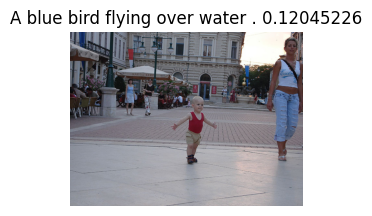

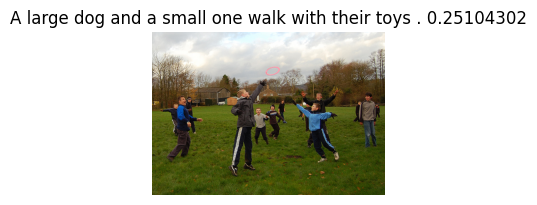

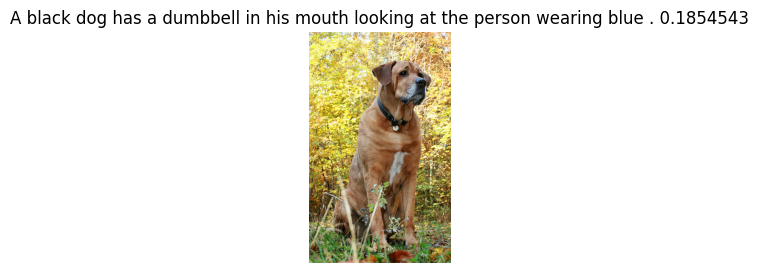

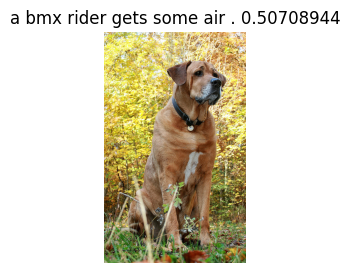

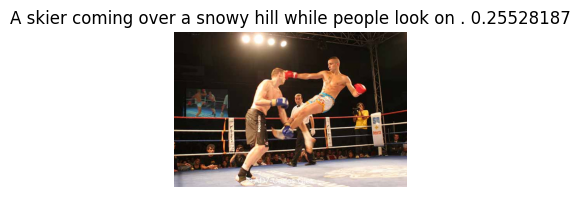

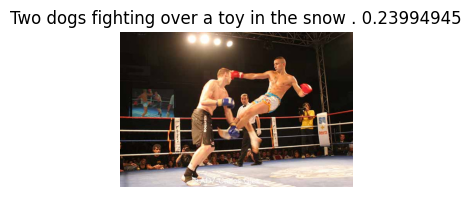

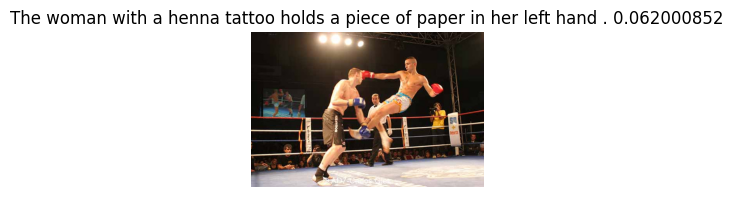

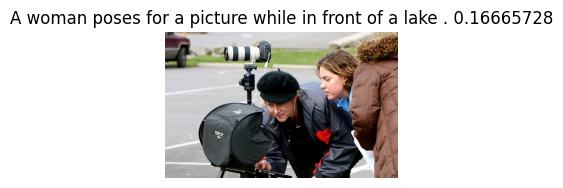

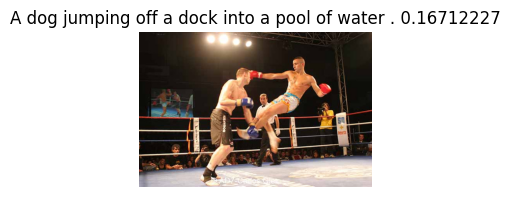

In [67]:
for item in ten_texts():
    res(item)

Тестирование показало неожиданный результат - на любое описание модель выдаёт одно и то же изображение. Возможно это происходит из-за недостаточного объёма данных. При бОльшем наборе результат должен быть лучше. Хотя судя по разным значениям метрики можно сделать вывод, что модель работает.

## Вывод

По предоставленным данным мной была проделана следующая работа:
 - были загружены необходимые библиотеки, выгружены и обработаны данные - изображения, их описания, оценки экспертов и других людей;
 - на основе этих данных были получены дополнительные признаки - общая оценка, принадлежность к запрещенному контенту;
 - векторизованы изображения;
 - векторизованы тексты;
 - векторы были объединены, получены 1422 новых признаков;
 - в качестве основной выбрали метрику RMSE;
 - данные разбиты на тренировочную и тестовую выборки;
 - были обучены две модели - линейная модель с регуляризацией Lasso Regression и полносвязная нейронная сеть;
 - по итогам обучения наилучшую метрику RMSE - 0.212 показала нейронная сеть, она и была выбрана для проверки на тестовых данных;
 - проведено тестирование модели, которое показало, что модель работает, но требуются дополнительные действия, например, увеличение тренировочных данных, для улучшения результата.
 
В итоге можно сделать вывод, что все выбранные инструменты и методы работают хорошо. Модель показывает определённый результат. Однако для более качественного результата при выборе изображения по запросу нужны более качественные данные, а набор данных должен быть гораздо больше. 